In [37]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import randint
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Loading the data

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Example for the data from fashion_mnist

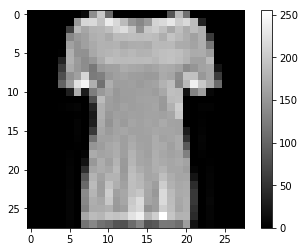

In [4]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Labels

In [5]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

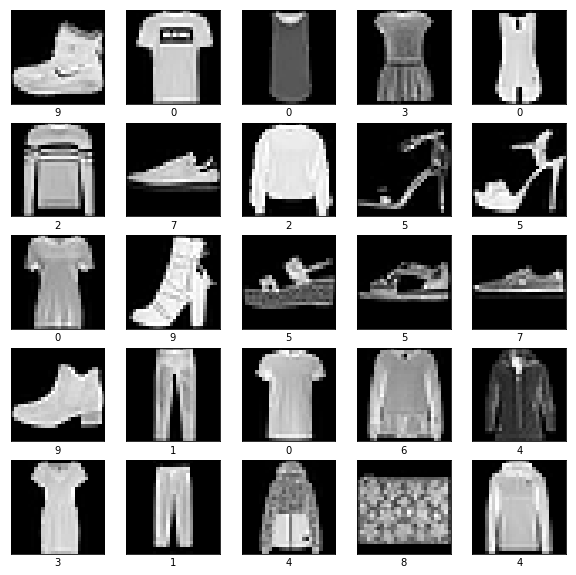

In [6]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

## Filter 1, 5 and 9 labels to create new data

Condition for getting only 1, 5 and 9 labels in every array

In [7]:
train_condition = ((train_labels == 1) | (train_labels == 5) | (train_labels == 9))
test_condition = ((test_labels == 1) | (test_labels == 5) | (test_labels == 9))

Filtering train and test data by the previous condition

In [8]:
train_labels_filtered = train_labels[train_condition]
train_images_filtered = train_images[train_condition]
test_labels_filtered = test_labels[test_condition]
test_images_filtered = test_images[test_condition]

In [9]:
print('Number of elements in train_labels_filtered: ', '{0:,}'.format(len(train_labels_filtered)))
print('Number of elements in train_iamges_filtered: ', '{0:,}'.format(len(train_images_filtered)))
print('Number of elements in train_labels_filtered: ', '{0:,}'.format(len(test_labels_filtered)))
print('Number of elements in train_iamges_filtered: ', '{0:,}'.format(len(test_images_filtered)))

Number of elements in train_labels_filtered:  18,000
Number of elements in train_iamges_filtered:  18,000
Number of elements in train_labels_filtered:  3,000
Number of elements in train_iamges_filtered:  3,000


Check for unique labels in new data

In [10]:
unique_train = np.unique(train_labels_filtered)
unique_test = np.unique(test_labels_filtered)
print('Labels for train data: ', unique_train)
print('Labels for test data: ', unique_test)

Labels for train data:  [1 5 9]
Labels for test data:  [1 5 9]


## Creating a label dictionary to match the description with each code

In [11]:
label_dict = dict()
label_dict[0] = ['T-shirt/top']
label_dict[1] = ['Trouser']
label_dict[2] = ['Pullover']
label_dict[3] = ['Dress']
label_dict[4] = ['Coat']
label_dict[5] = ['Sandal']
label_dict[6] = ['Shirt']
label_dict[7] = ['Sneaker']
label_dict[8] = ['Bag']
label_dict[9] = ['Ankle boot']

In [12]:
label_dict

{0: ['T-shirt/top'],
 1: ['Trouser'],
 2: ['Pullover'],
 3: ['Dress'],
 4: ['Coat'],
 5: ['Sandal'],
 6: ['Shirt'],
 7: ['Sneaker'],
 8: ['Bag'],
 9: ['Ankle boot']}

## Defining the function for the Logistic Regression

In [13]:
def logistic_model(epochs, lr, batch, x_model, y_model, W_model, b_model, k):
    
    tf.reset_default_graph()
    
    #Hyperparameters
    epochs = epochs #parameter of the function
    lr = lr #parameter of the function
    
    #Learnable parameters
    W = tf.Variable(W_model, name = 'W')
    b = tf.Variable(b_model, name = 'b')
    
    #Other parameters
    k = k #parameter of the function: prints every k
    batch_size = batch
    m = x_model.shape[1] #parameter of the function for the number of columns of matrix x
    y_col = y_model.shape[1] #parameter of the function for the number of columns of matrix y
    
    #Model variables
    X = tf.placeholder('float64', name = 'X', shape = [batch_size, m])
    Y = tf.placeholder('float64', name = 'Y', shape = [batch_size, y_col])
    
    #Hypothesis
    with tf.name_scope('Hypothesis'):
        logits = tf.add(tf.matmul(X, W, name = 'Matrix_Product'), b, name = 'Logits')
        y_hat = tf.nn.softmax(logits, name = 'Hypothesis_Softmax')
    
    #Cost Function
    with tf.name_scope('Cost_Function'):
        error = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(y_hat), reduction_indices=[1]))
    
    #Gradient Descent
    with tf.name_scope('Gradient'):
        optimizer = tf.train.GradientDescentOptimizer(lr).minimize(error)
    
    #For accuracy
    with tf.name_scope('Accuracy'):
        correct_prediction = tf.equal(tf.argmax(y_hat,1), tf.argmax(Y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    #Creating error summaries
    error_summary = tf.summary.scalar(name = 'Error_Summary', tensor = error)
    accuracy_summary = tf.summary.scalar(name = 'Accuracy_Summary', tensor = accuracy)
    
    graph_dir = (
        './graphs/graph_epochs='+str(epochs)+
        '_lr='+str(lr)+
        '_batch='+str(batch)
    )
    
    with tf.Session() as sess:
        
        tf.initialize_all_variables().run()
        print('Variables successfully initialized')
        
        writer = tf.summary.FileWriter(graph_dir, sess.graph)
        print('Directory created in', graph_dir)
        
        for epoch in range(epochs):
            
            forBatch = (epoch * batch_size) % (x_train.shape[0] - batch_size)
            #print(forBatch)
            feed_dict = {X : x_train[forBatch:(forBatch+batch_size)], 
                         Y : y_train[forBatch:(forBatch+batch_size)]}

            sess.run(optimizer, feed_dict)

            if (epoch+1)%k == 0:

                e,a = sess.run([error,accuracy], feed_dict)
                
                #running the summaries
                e_summary = sess.run(error_summary, feed_dict)
                a_summary = sess.run(accuracy_summary, feed_dict)
                writer.add_summary(e_summary, epoch)
                writer.add_summary(a_summary, epoch)
                
                print('Epoch = ', epoch+1, ': error = ', e, ', accuracy = ', a, sep = '')
        writer.close()
        return((W.eval(),b.eval()))
    sess.close()

## Graph of the Model using Gradient Descent Optimizer
<img src="GraphTB_Logistic.png">

## Feature engineering

### Transforming x and y

In [22]:
x_train = train_images_filtered.reshape(len(train_images_filtered), 
                                        train_images_filtered.shape[1]*train_images_filtered.shape[2])
x_train = x_train.astype(float)

y_train = pd.DataFrame({'y': train_labels_filtered})
y_train = pd.get_dummies(y_train['y']).astype(float)

print('Dimensions for x_train data: ', x_train.shape)
print('Dimensions for y_train data: ', y_train.shape)

Dimensions for x_train data:  (18000, 784)
Dimensions for y_train data:  (18000, 3)


### Initial values for Weights and Bias

In [23]:
#To initialize weights
w_train = np.random.rand(x_train.shape[1],y_train.shape[1])*10
print('Dimensions for Weights: ', w_train.shape)
#for i in range(0,len(w_train)):
#    print('Variable ', i+1, ' Initial Weight: ', w_train[i], sep = '')
#To initialize weights
b_train = (np.random.rand(1,3)*10).reshape(1,y_train.shape[1])
print('Dimension for Bias:', b_train.shape)

Dimensions for Weights:  (784, 3)
Dimension for Bias: (1, 3)


# Results

## Model 1: 

- epochs = 1000
- lr = 1
- batch = 32
- images pixels aren't normalized

In [24]:
model_1 = logistic_model(
    epochs = 1000, 
    lr = 1, 
    batch = 32, 
    x_model = x_train, 
    y_model = y_train, 
    W_model = w_train,
    b_model = b_train,
    k = 50
)

Variables successfully initialized
Directory created in ./graphs/graph_epochs=1000_lr=1_batch=32
Epoch = 50: error = nan, accuracy = 0.3125
Epoch = 100: error = nan, accuracy = 0.375
Epoch = 150: error = nan, accuracy = 0.34375
Epoch = 200: error = nan, accuracy = 0.21875
Epoch = 250: error = nan, accuracy = 0.4375
Epoch = 300: error = nan, accuracy = 0.1875
Epoch = 350: error = nan, accuracy = 0.40625
Epoch = 400: error = nan, accuracy = 0.53125
Epoch = 450: error = nan, accuracy = 0.28125
Epoch = 500: error = nan, accuracy = 0.25
Epoch = 550: error = nan, accuracy = 0.25
Epoch = 600: error = nan, accuracy = 0.46875
Epoch = 650: error = nan, accuracy = 0.4375
Epoch = 700: error = nan, accuracy = 0.4375
Epoch = 750: error = nan, accuracy = 0.375
Epoch = 800: error = nan, accuracy = 0.34375
Epoch = 850: error = nan, accuracy = 0.4375
Epoch = 900: error = nan, accuracy = 0.25
Epoch = 950: error = nan, accuracy = 0.25
Epoch = 1000: error = nan, accuracy = 0.25


As we can see in data without normalizing is that the error is giving a 'Not a number' issue. And, for the accuracy, we're seeing an apparent random or guessing error (1 out of 3).

<img src="not_normalized_accuracy.png">

### Normalization

Now we're going to normalize the pixels of the images by dividing it to the max number (255).

In [26]:
x_train = train_images_filtered.reshape(len(train_images_filtered), 
                                        train_images_filtered.shape[1]*train_images_filtered.shape[2])
x_train = x_train/255

y_train = pd.DataFrame({'y': train_labels_filtered})
y_train = pd.get_dummies(y_train['y']).astype(float)

print('Dimensions for x_train data: ', x_train.shape)
print('Dimensions for y_train data: ', y_train.shape)

Dimensions for x_train data:  (18000, 784)
Dimensions for y_train data:  (18000, 3)


## Model 2:

- epochs = 1000
- lr = 1
- batch = 32
- images pixels normalized

In [28]:
model_2 = logistic_model(
    epochs = 1000, 
    lr = 1, 
    batch = 32, 
    x_model = x_train, 
    y_model = y_train, 
    W_model = w_train,
    b_model = b_train,
    k = 50
)

Variables successfully initialized
Directory created in ./graphs/graph_epochs=1000_lr=1_batch=32
Epoch = 50: error = 5.116977588609596, accuracy = 0.6875
Epoch = 100: error = 2.3330858498337332, accuracy = 0.9375
Epoch = 150: error = 0.0016643359757990714, accuracy = 1.0
Epoch = 200: error = 0.4298099124643443, accuracy = 0.9375
Epoch = 250: error = 0.4047697150383761, accuracy = 0.96875
Epoch = 300: error = 0.00016095925634594538, accuracy = 1.0
Epoch = 350: error = 0.02737170307285664, accuracy = 0.96875
Epoch = 400: error = 0.2836243956855326, accuracy = 0.96875
Epoch = 450: error = 0.211994949256662, accuracy = 0.96875
Epoch = 500: error = 0.8521056064005988, accuracy = 0.90625
Epoch = 550: error = 0.6292834761602841, accuracy = 0.90625
Epoch = 600: error = 0.00016064390708459317, accuracy = 1.0
Epoch = 650: error = 0.5385557159713633, accuracy = 0.9375
Epoch = 700: error = 0.006126963908302962, accuracy = 1.0
Epoch = 750: error = 4.5970807469307566e-05, accuracy = 1.0
Epoch = 800:

### Accuracy for Model 2
<img src="accuracy_lr=1.png">

### Error for Model 2
<img src="error_lr=1.png">

## Model 3:

- epochs = 1000
- lr = 0.1
- batch = 32
- images pixels normalized

In [30]:
model_3 = logistic_model(
    epochs = 1000, 
    lr = 0.1, 
    batch = 32, 
    x_model = x_train, 
    y_model = y_train, 
    W_model = w_train,
    b_model = b_train,
    k = 50
)

Variables successfully initialized
Directory created in ./graphs/graph_epochs=1000_lr=0.1_batch=32
Epoch = 50: error = 12.160396357866578, accuracy = 0.53125
Epoch = 100: error = 3.4192645145388294, accuracy = 0.78125
Epoch = 150: error = 0.5363725349928119, accuracy = 0.90625
Epoch = 200: error = 2.1658695846045664, accuracy = 0.84375
Epoch = 250: error = 2.511048310739775, accuracy = 0.78125
Epoch = 300: error = 1.027533376920532, accuracy = 0.875
Epoch = 350: error = 1.3084138729369248, accuracy = 0.90625
Epoch = 400: error = 2.1378555807135213, accuracy = 0.84375
Epoch = 450: error = 1.4021040366174071, accuracy = 0.84375
Epoch = 500: error = 3.1180775815862667, accuracy = 0.875
Epoch = 550: error = 2.88437309273034, accuracy = 0.71875
Epoch = 600: error = 0.8618269986876874, accuracy = 0.875
Epoch = 650: error = 1.7868685167695664, accuracy = 0.875
Epoch = 700: error = 0.21248675725815913, accuracy = 0.9375
Epoch = 750: error = 0.7122665614233761, accuracy = 0.9375
Epoch = 800: er

### Accuracy for Model 3
<img src="accuracy_lr=0.1.png">

### Error for Model 3
<img src="error_lr=0.1.png">

## Model 4:

- epochs = 1000
- lr = 0.01
- batch = 32
- images pixels normalized

In [31]:
model_4 = logistic_model(
    epochs = 1000, 
    lr = 0.01, 
    batch = 32, 
    x_model = x_train, 
    y_model = y_train, 
    W_model = w_train,
    b_model = b_train,
    k = 50
)

Variables successfully initialized
Directory created in ./graphs/graph_epochs=1000_lr=0.01_batch=32
Epoch = 50: error = 30.689783972268977, accuracy = 0.25
Epoch = 100: error = 11.096902716821848, accuracy = 0.3125
Epoch = 150: error = 7.542822550682631, accuracy = 0.6875
Epoch = 200: error = 5.851983998707906, accuracy = 0.53125
Epoch = 250: error = 7.524160868641762, accuracy = 0.53125
Epoch = 300: error = 6.4302089812263805, accuracy = 0.65625
Epoch = 350: error = 7.200704113266262, accuracy = 0.65625
Epoch = 400: error = 6.805149887858776, accuracy = 0.71875
Epoch = 450: error = 6.383453964011748, accuracy = 0.5625
Epoch = 500: error = 5.239741584939724, accuracy = 0.75
Epoch = 550: error = 7.427957370519485, accuracy = 0.46875
Epoch = 600: error = 3.3236065926890577, accuracy = 0.71875
Epoch = 650: error = 2.6886173264280533, accuracy = 0.6875
Epoch = 700: error = 0.8135152461735968, accuracy = 0.84375
Epoch = 750: error = 3.2845564330097865, accuracy = 0.78125
Epoch = 800: error 

### Accuracy for Model 4
<img src="accuracy_lr=0.01.png">

### Error for Model 4
<img src="error_lr=0.01.png">

## Model 5:

- epochs = 1000
- lr = 10
- batch = 32
- images pixels normalized

In [32]:
model_5 = logistic_model(
    epochs = 1000, 
    lr = 10, 
    batch = 32, 
    x_model = x_train, 
    y_model = y_train, 
    W_model = w_train,
    b_model = b_train,
    k = 50
)

Variables successfully initialized
Directory created in ./graphs/graph_epochs=1000_lr=10_batch=32
Epoch = 50: error = nan, accuracy = 0.3125
Epoch = 100: error = nan, accuracy = 0.375
Epoch = 150: error = nan, accuracy = 0.34375
Epoch = 200: error = nan, accuracy = 0.21875
Epoch = 250: error = nan, accuracy = 0.4375
Epoch = 300: error = nan, accuracy = 0.1875
Epoch = 350: error = nan, accuracy = 0.40625
Epoch = 400: error = nan, accuracy = 0.53125
Epoch = 450: error = nan, accuracy = 0.28125
Epoch = 500: error = nan, accuracy = 0.25
Epoch = 550: error = nan, accuracy = 0.25
Epoch = 600: error = nan, accuracy = 0.46875
Epoch = 650: error = nan, accuracy = 0.4375
Epoch = 700: error = nan, accuracy = 0.4375
Epoch = 750: error = nan, accuracy = 0.375
Epoch = 800: error = nan, accuracy = 0.34375
Epoch = 850: error = nan, accuracy = 0.4375
Epoch = 900: error = nan, accuracy = 0.25
Epoch = 950: error = nan, accuracy = 0.25
Epoch = 1000: error = nan, accuracy = 0.25


While the **Learning Rate** is getting down, the accuracy is decreasing as well and the error is increasing. This means that the best Model is the **Model 2**. This model has the best accuracy and the lowest error from all the models as we can see in this brief summary for both metrics:

Legend:

<img src="legend.png" width="300" align="left">

### Accuracy for All Models
<img src="accuracy_lr=all.png">

### Error for All Models
<img src="error_lr=all.png">

## Defining model to predict the category for each image

This function will receive 4 arguments:
1. logistic_model: tuple of weights and biases from a logistic model
2. X_raw: Tensor containing the image
3. X: Tensor containing the image reshaped for each feature to be in a column
4. Y: The correct category for each image

In [47]:
def predicting_image(logistic_model, X_raw, X, Y):
    plt.imshow(X_raw, cmap = 'gray')
    plt.colorbar()
    logits = np.matmul(X,logistic_model[0]) + logistic_model[1]
    y_hat = tf.nn.softmax(logits)
    with tf.Session() as sess:
        y_predicted = y_hat.eval()
        keys = unique_test
        category = keys[np.argmax(y_predicted)]
        print('This image belongs to the category -', 
              label_dict[category][0], 
              '- with a probability of -', 
              np.round(np.max(y_predicted),3),
              '-',
              sep = '')
        print('Correct category in test set: -', label_dict[Y.idxmax()][0], '-', sep = '')
    sess.close()

## Transforming x and y test sets with normalization

In [48]:
x_test = test_images_filtered.reshape(len(test_images_filtered), 
                                      test_images_filtered.shape[1]*test_images_filtered.shape[2])
x_test = x_test.astype(float)/255
y_test = pd.DataFrame({'y': test_labels_filtered})
y_test = pd.get_dummies(y_test['y']).astype(float)

### Random image generation

We need a random image generation to predict the category for that specific image. The function is defined below:

In [49]:
def random_image_generation(image_df):
    image_number = randint(0,image_df.shape[0])
    return(image_number)

## Predicting category of image

Now, we can predict a random image from the test set using the best trained model: **Model 2**

Image #2388
This image belongs to the category -Sandal- with a probability of -0.994-
Correct category in test set: -Sandal-


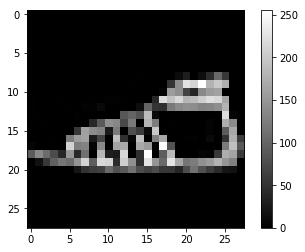

In [65]:
random_image = random_image_generation(test_images_filtered)
print('Image #', random_image, sep='')
predicting_image(model_2, test_images_filtered[random_image], x_test[random_image], y_test.iloc[random_image])

We can see that the **Image #2388** is predicted correctly as a **Sandal** with a probability of **99.4%**.

## Predicting 5 Random Images

Image #2869
This image belongs to the category -Trouser- with a probability of -1.0-
Correct category in test set: -Trouser-


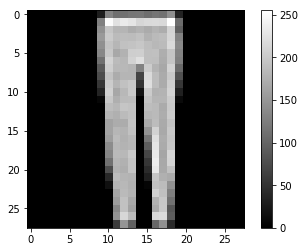

In [67]:
random_image = random_image_generation(test_images_filtered)
print('Image #', random_image, sep='')
predicting_image(model_2, test_images_filtered[random_image], x_test[random_image], y_test.iloc[random_image])

Image #252
This image belongs to the category -Trouser- with a probability of -1.0-
Correct category in test set: -Trouser-


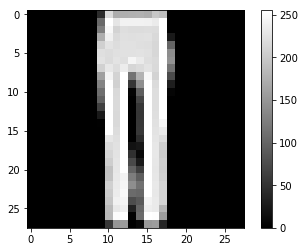

In [68]:
random_image = random_image_generation(test_images_filtered)
print('Image #', random_image, sep='')
predicting_image(model_2, test_images_filtered[random_image], x_test[random_image], y_test.iloc[random_image])

Image #2620
This image belongs to the category -Ankle boot- with a probability of -1.0-
Correct category in test set: -Sandal-


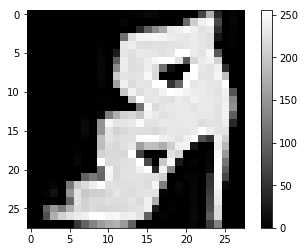

In [69]:
random_image = random_image_generation(test_images_filtered)
print('Image #', random_image, sep='')
predicting_image(model_2, test_images_filtered[random_image], x_test[random_image], y_test.iloc[random_image])

Image #932
This image belongs to the category -Ankle boot- with a probability of -0.988-
Correct category in test set: -Ankle boot-


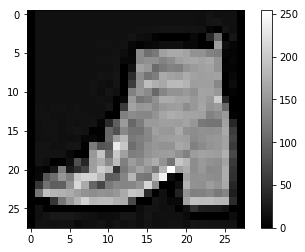

In [70]:
random_image = random_image_generation(test_images_filtered)
print('Image #', random_image, sep='')
predicting_image(model_2, test_images_filtered[random_image], x_test[random_image], y_test.iloc[random_image])

Image #961
This image belongs to the category -Trouser- with a probability of -1.0-
Correct category in test set: -Trouser-


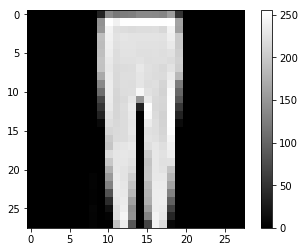

In [71]:
random_image = random_image_generation(test_images_filtered)
print('Image #', random_image, sep='')
predicting_image(model_2, test_images_filtered[random_image], x_test[random_image], y_test.iloc[random_image])